## Import Packages

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.optimize import curve_fit

C:\Users\Dell Precision\AppData\Local\Temp\ipykernel_11472\3566873857.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Function Definition

In [16]:
def fill_missing_data(signal_with_noise):
    # Interpolate missing data
    interpolated_signal = signal_with_noise.copy()
    missing_mask = np.isnan(signal_with_noise)
    interpolated_signal[missing_mask] = np.interp(
        np.flatnonzero(missing_mask),
        np.flatnonzero(~missing_mask),
        interpolated_signal[~missing_mask]
    )

    return interpolated_signal

# Design Butterworth low-pass filter
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def make_angles_continuous(angles):
    """
    Convert angles to continuously increasing angles.

    Parameters:
    angles (array-like): Array of angles ranging from -180 to 180.

    Returns:
    continuous_angles (array-like): Array of continuously increasing angles.
    """
    continuous_angles = np.zeros_like(angles)
    previous_angle = angles[0]
    for i, angle in enumerate(angles):
        if i > 0:
            diff = angle - previous_angle
            if diff < -180:
                diff += 360
            elif diff > 180:
                diff -= 360
            continuous_angles[i] = continuous_angles[i-1] + diff
        else:
            continuous_angles[i] = angle
        previous_angle = angle

    return continuous_angles

def fit_constant_force(df, type):

    def func(x, a, b, c):
        return a * np.exp(-b * x) + c

    popt, pcov = curve_fit(func, df["t (s)"], df[type])

def process_signal(type, df, polyfit = False, savgol = False):

    y = fill_missing_data(df[type])

    if type[0] == "a":
        y = make_angles_continuous(y)

    if polyfit == True:
        poly = np.polyfit(df["t (s)"], y, deg=2)
        filtered_signal = np.polyval(poly, df["t (s)"])

    elif savgol == True:
        filtered_signal = signal.savgol_filter(y, 160, 3)

    else:

        # Filter requirements
        order = 4
        fs = 30  # sample rate, Hz
        cutoff = 0.5
    
        if type[0] == "a":
            cutoff = 1  # desired cutoff frequency of the filter, Hz

        # Apply the Butterworth low-pass filter
        filtered_signal = butter_lowpass_filter(y, cutoff, fs, order)

    return filtered_signal

def calculate_derivative(positions, time):
    """
    Calculate velocity from positions over time using central differences.

    Parameters:
    positions (array-like): Array of positions.
    time (array-like): Array of time corresponding to positions.

    Returns:
    velocity (array-like): Array of velocities.
    """
    # Calculate time differences
    dt = np.diff(time)

    # Calculate position differences
    dp = np.diff(positions)

    # Calculate velocity using central differences
    velocity = dp / dt

    # Pad the velocity array to match the length of time array
    velocity = np.concatenate(([velocity[0]], velocity))

    return velocity

def plot_all(df, type, filtered_signal, velocity, accel):

    # Create a figure and subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Plot original and filtered signals
    axs[0].plot(df["t (s)"], df[type], label="Original")
    axs[0].plot(df["t (s)"], filtered_signal, label="Filtered")
    axs[0].set_xlabel("t (s)")
    axs[0].set_ylabel(type)
    axs[0].legend()

    # Plot velocity vs time
    axs[1].plot(df["t (s)"], velocity)
    axs[1].set_title("Velocity vs Time")
    axs[1].set_xlabel("t (s)")
    if type[0] == "a":
        axs[1].set_ylabel("deg/s")
    else:
        axs[1].set_ylabel("mm/s")

    # Plot acceleration vs time
    axs[2].plot(df["t (s)"], accel)
    axs[2].set_title("Acceleration vs Time")
    axs[2].set_xlabel("t (s)")
    if type[0] == "a":
        axs[2].set_ylabel("deg/s^2")
    else:
        axs[2].set_ylabel("mm/s^2")

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

def get_accel(type, df, polyfit = False, savgol = False):
    filtered_signal = process_signal(type, df, polyfit, savgol)

    velocity = calculate_derivative(filtered_signal, df["t (s)"])

    accel = calculate_derivative(velocity, df["t (s)"])

    plot_all(df, type, filtered_signal, velocity, accel)

    return accel


## Load Data

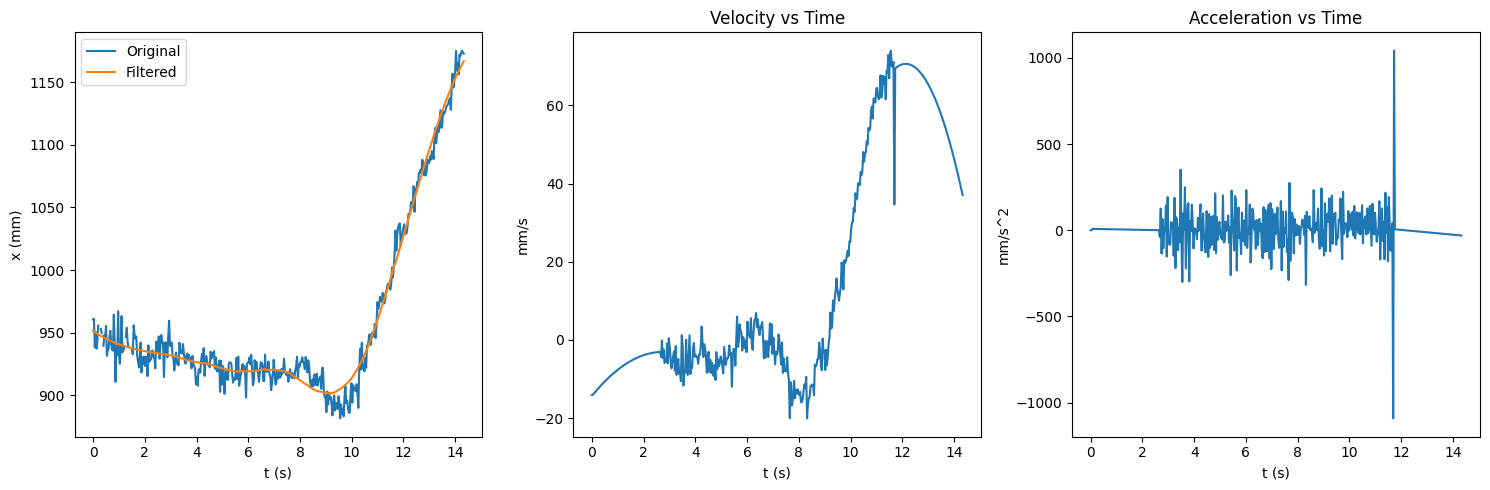

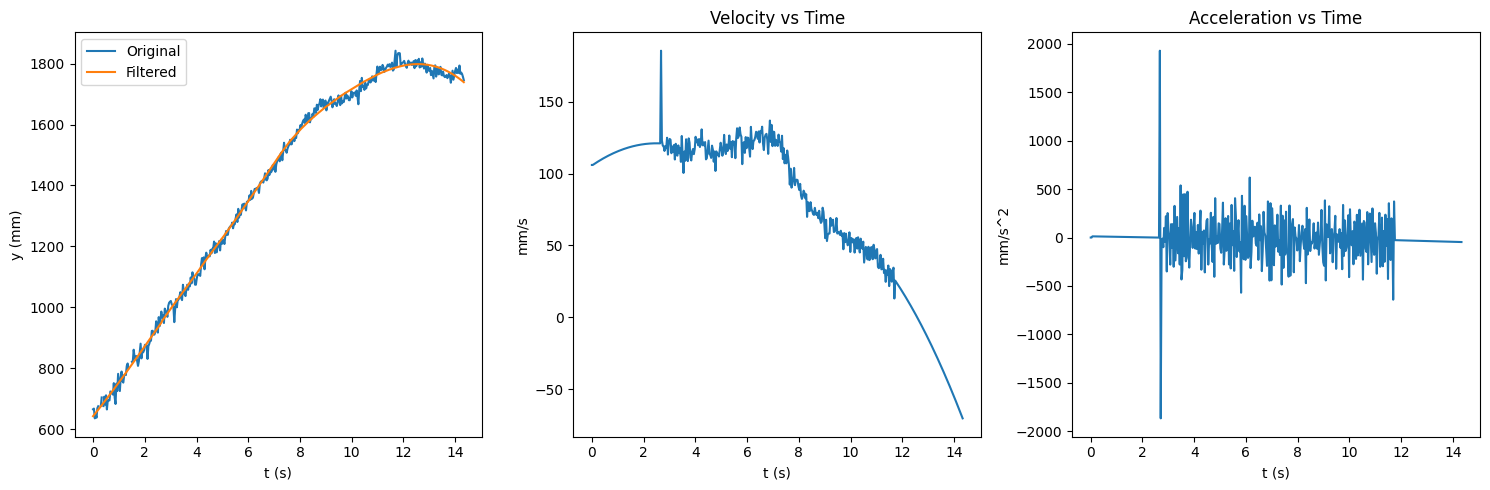

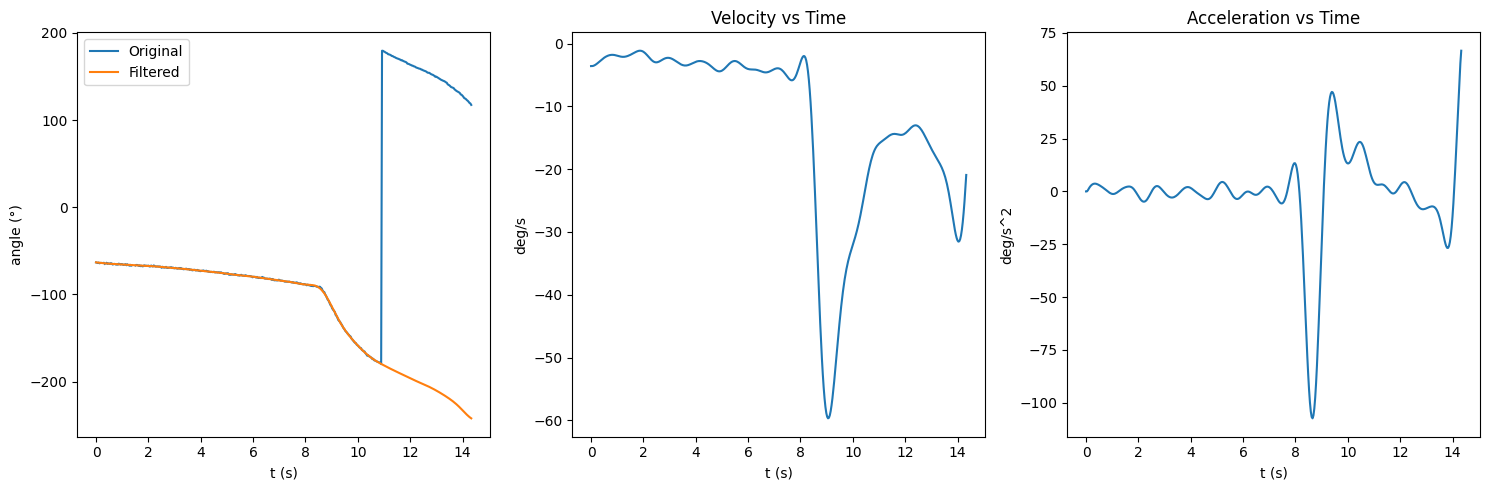

In [17]:
filename = "bigDisturbance_left_top_1.csv"
df = pd.read_csv(filename)  # [:250] before disturbance

type = "x (mm)"
accel = get_accel(type, df)

type = "y (mm)"
accel = get_accel(type, df)

type = "angle (°)"
accel = get_accel(type, df)

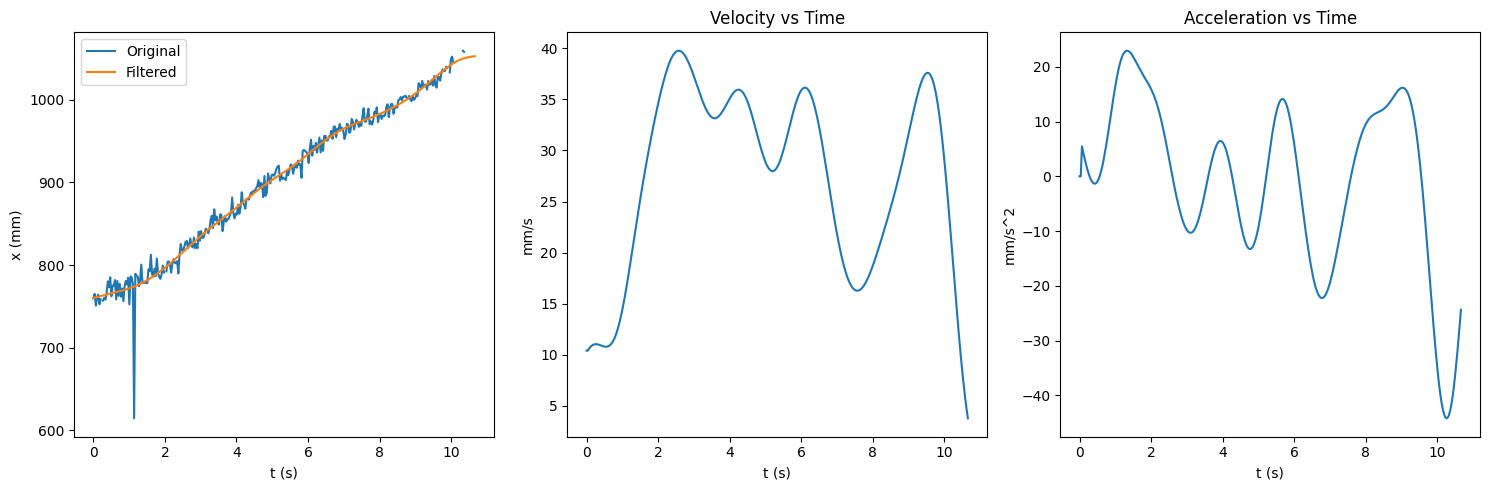

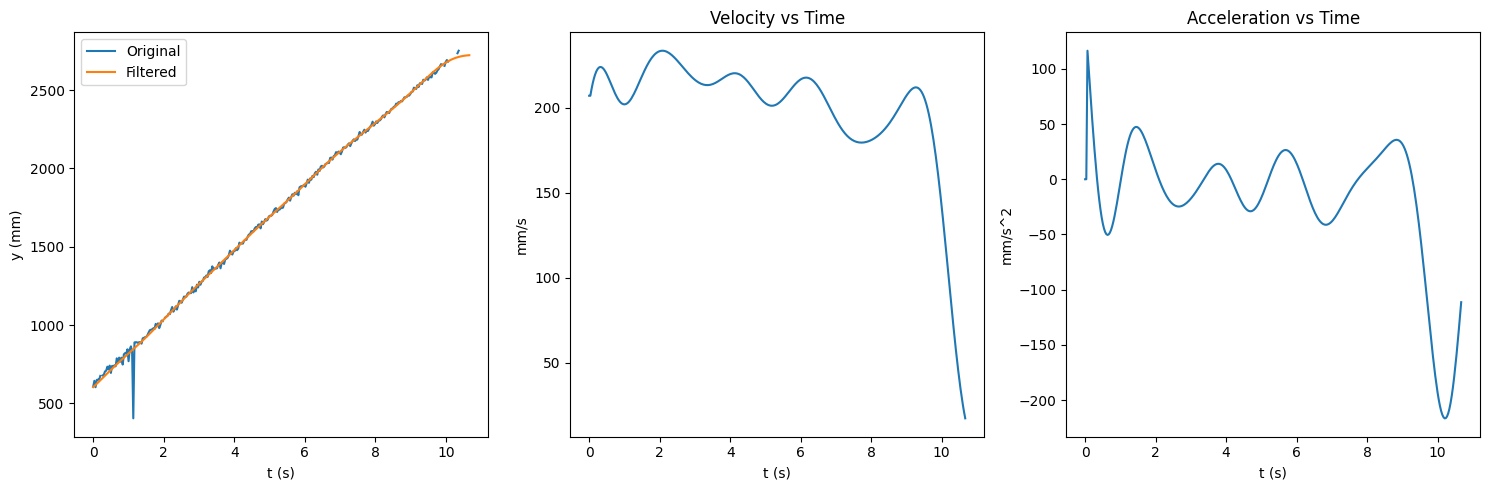

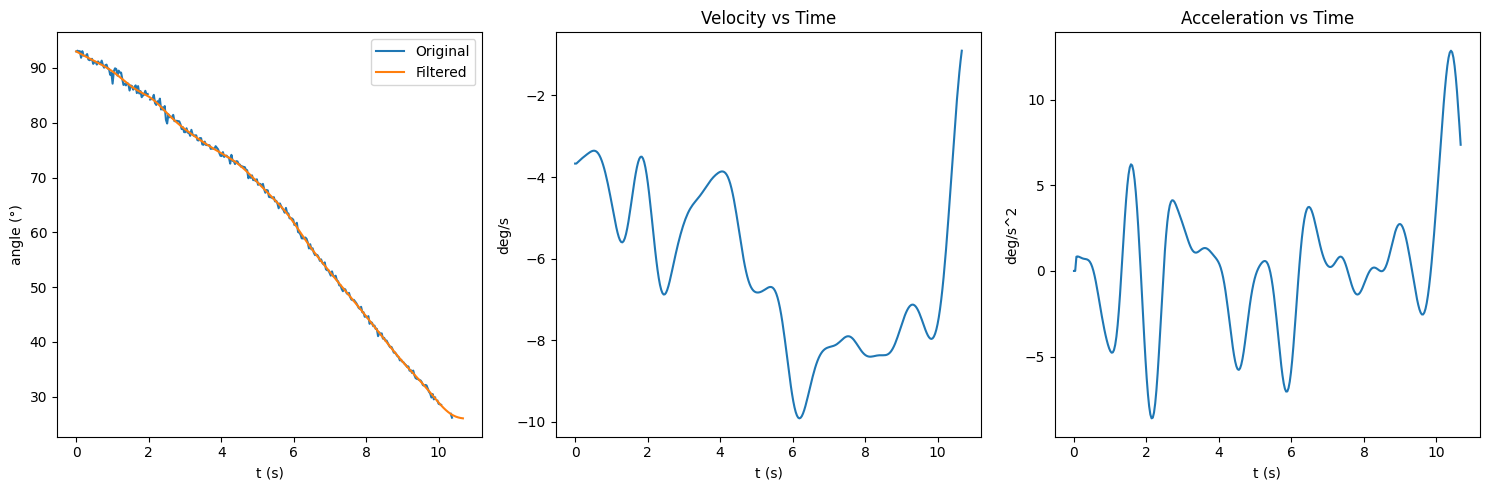

In [19]:
filename = "fullTableLine_left_top_1.csv"
df = pd.read_csv(filename)

type = "x (mm)"
accel = get_accel(type, df)

type = "y (mm)"
accel = get_accel(type, df)

type = "angle (°)"
accel = get_accel(type, df)

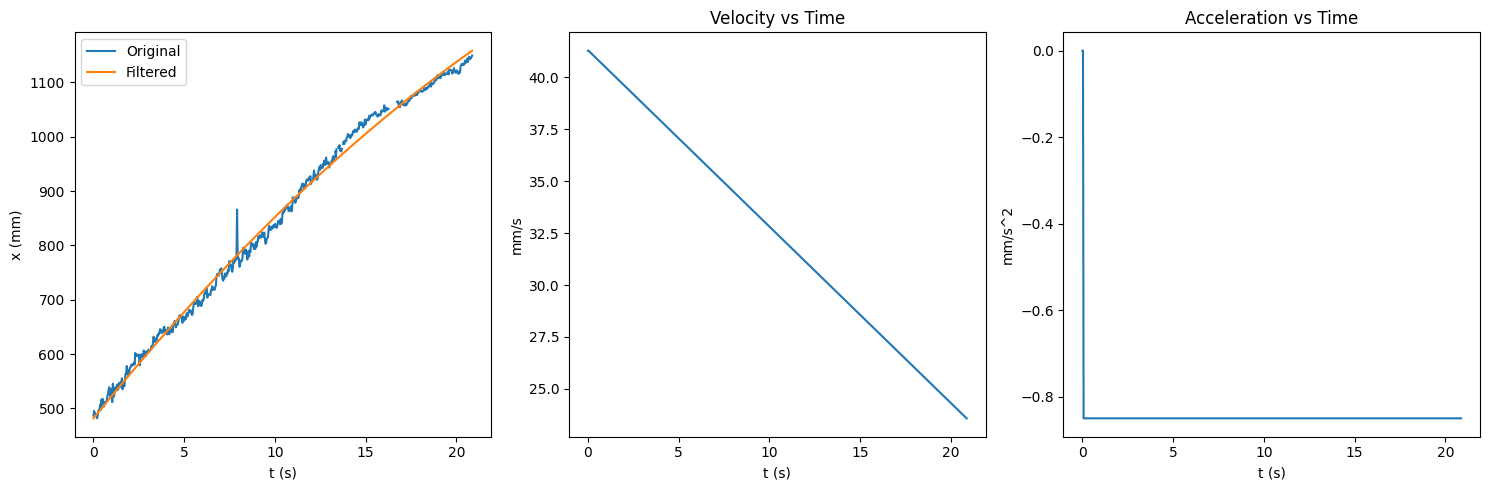

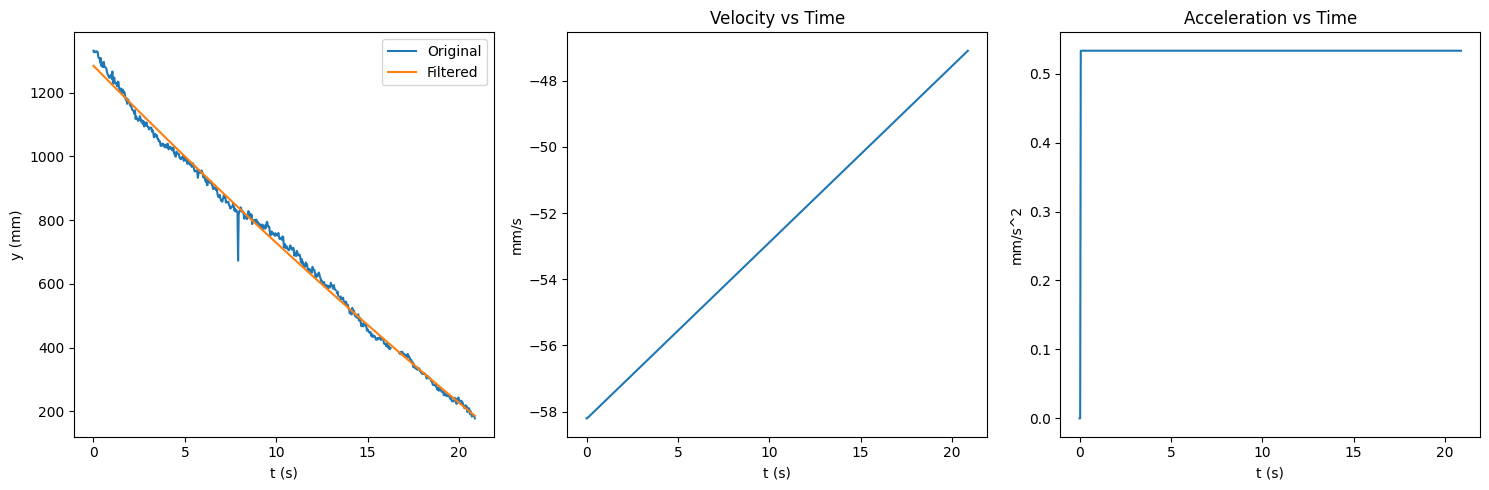

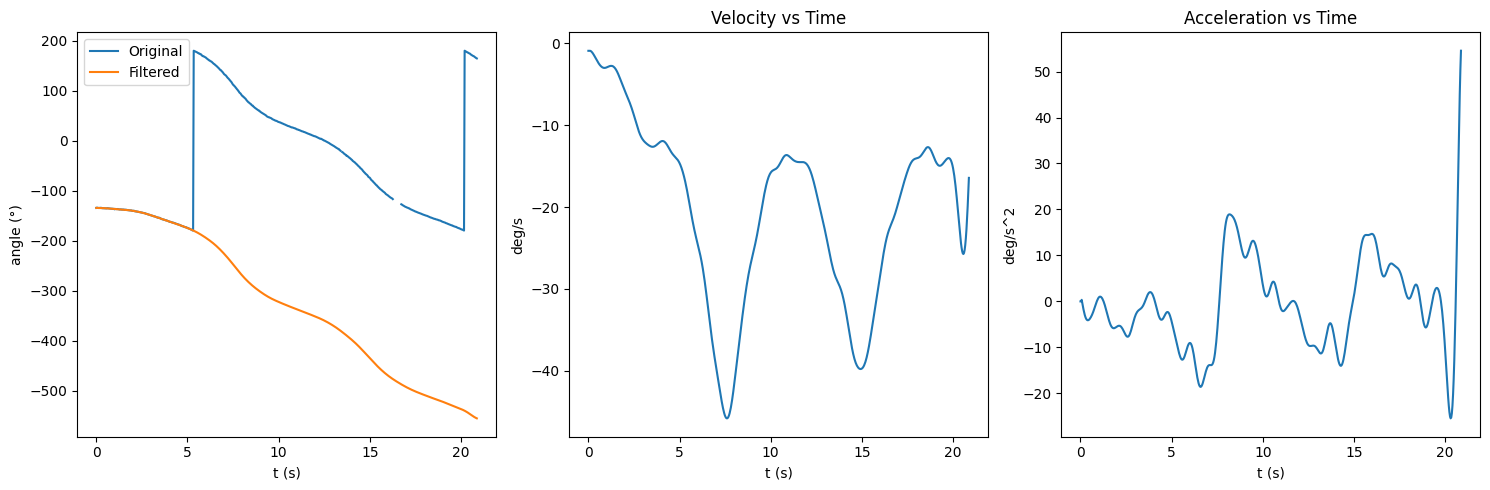

In [16]:
filename = "line_left_bottom_1.csv"
df = pd.read_csv(filename)

type = "x (mm)"
accel = get_accel(type, df, polyfit = True)

type = "y (mm)"
accel = get_accel(type, df, polyfit = True)

type = "angle (°)"
accel = get_accel(type, df)

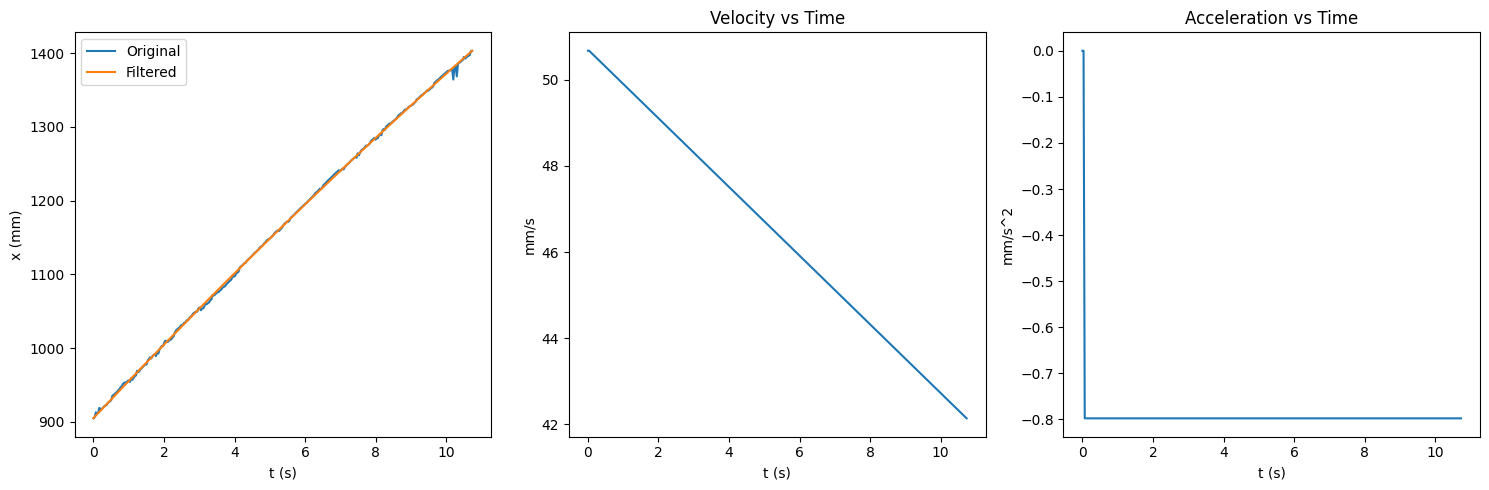

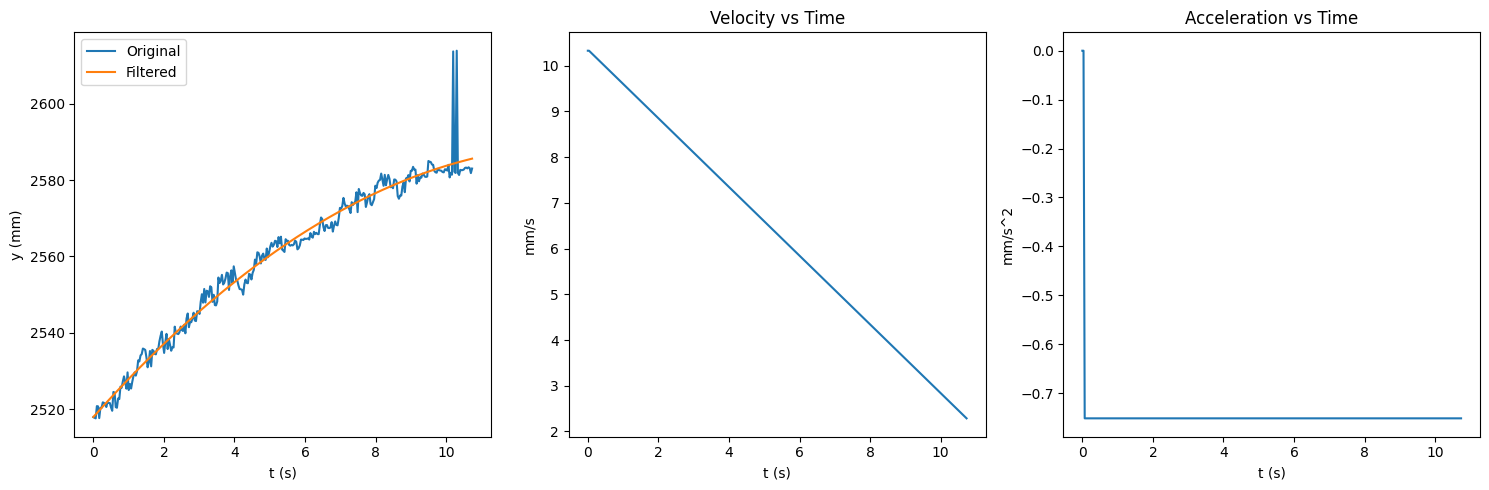

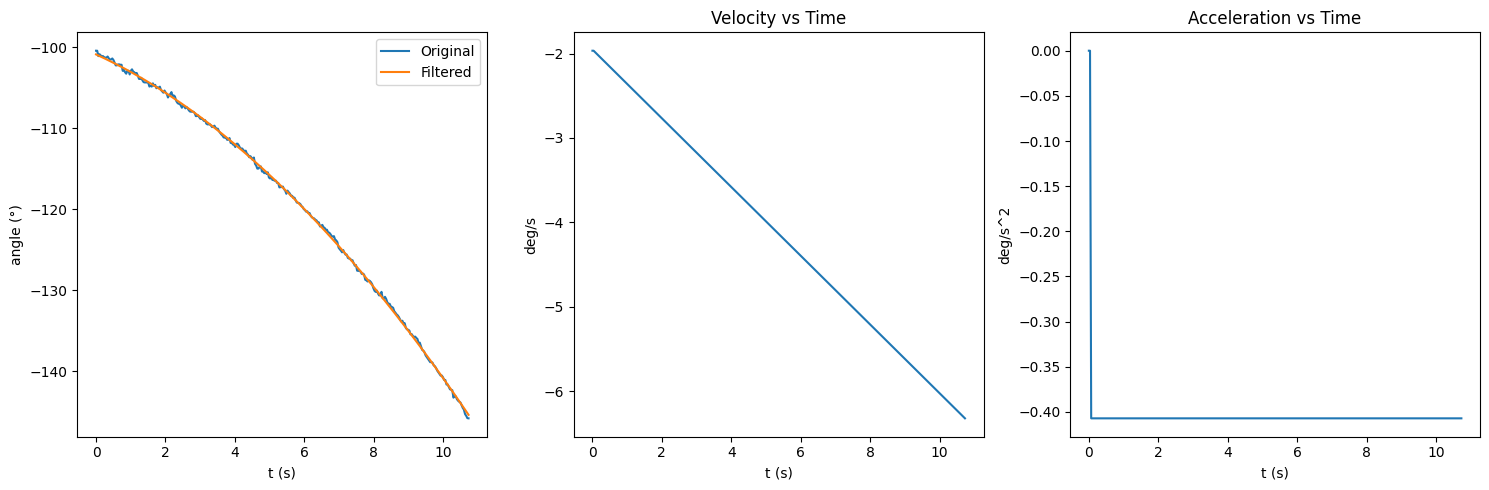

In [57]:
filename = "line_right_top_1.csv"
df = pd.read_csv(filename)

type = "x (mm)"
accel = get_accel(type, df, polyfit=True)

type = "y (mm)"
accel = get_accel(type, df, polyfit=True)

type = "angle (°)"
accel = get_accel(type, df, polyfit=True)

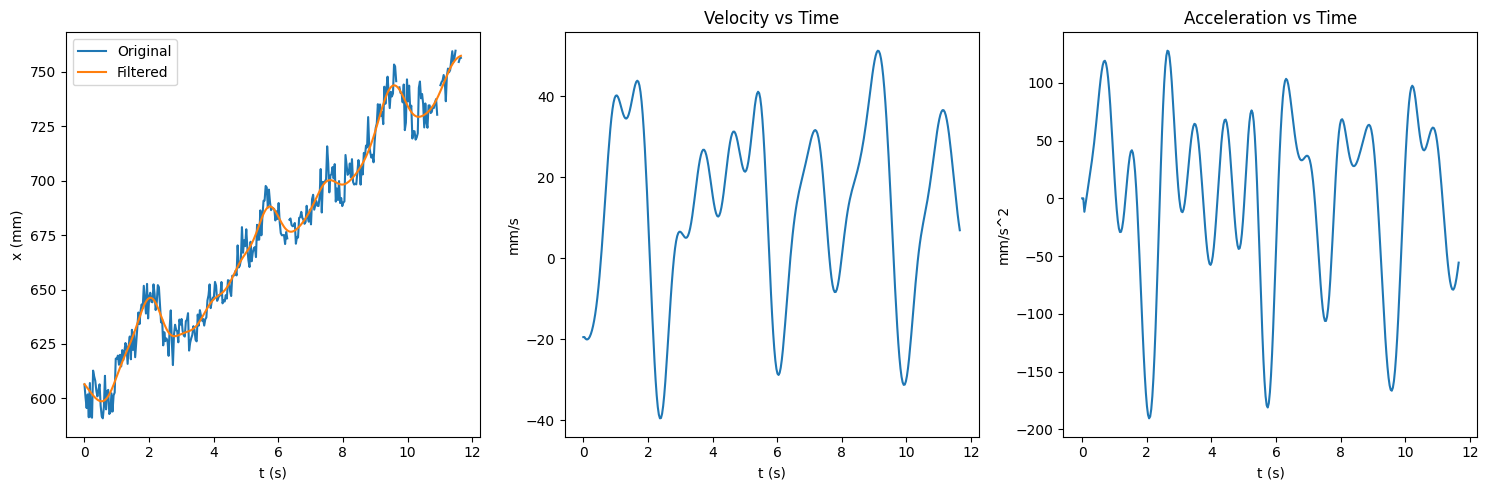

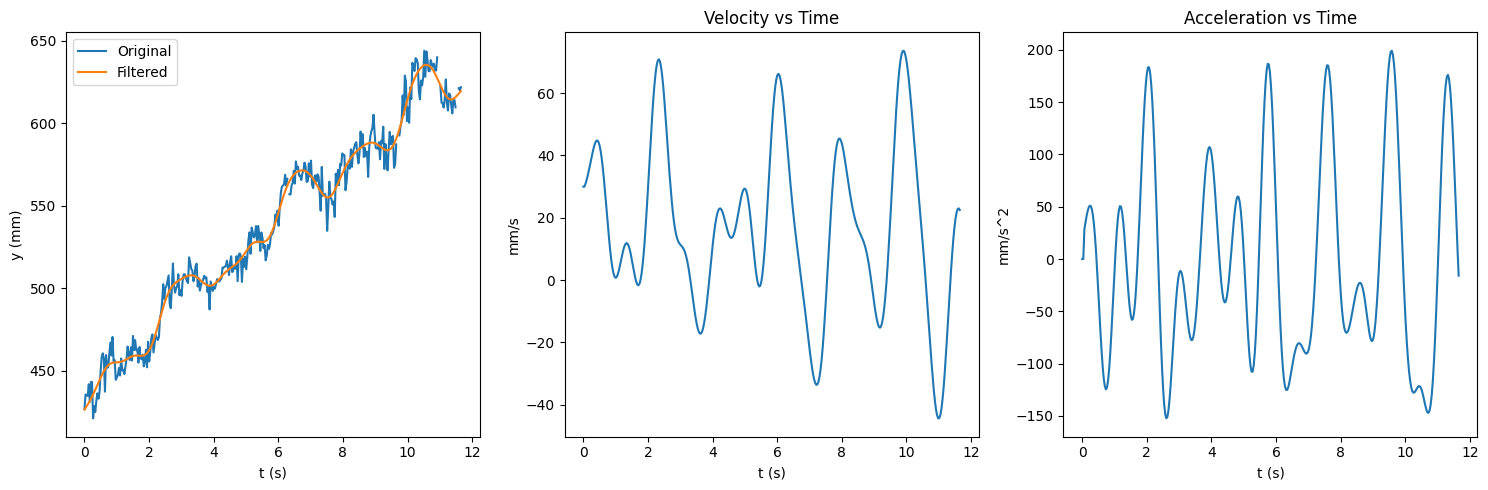

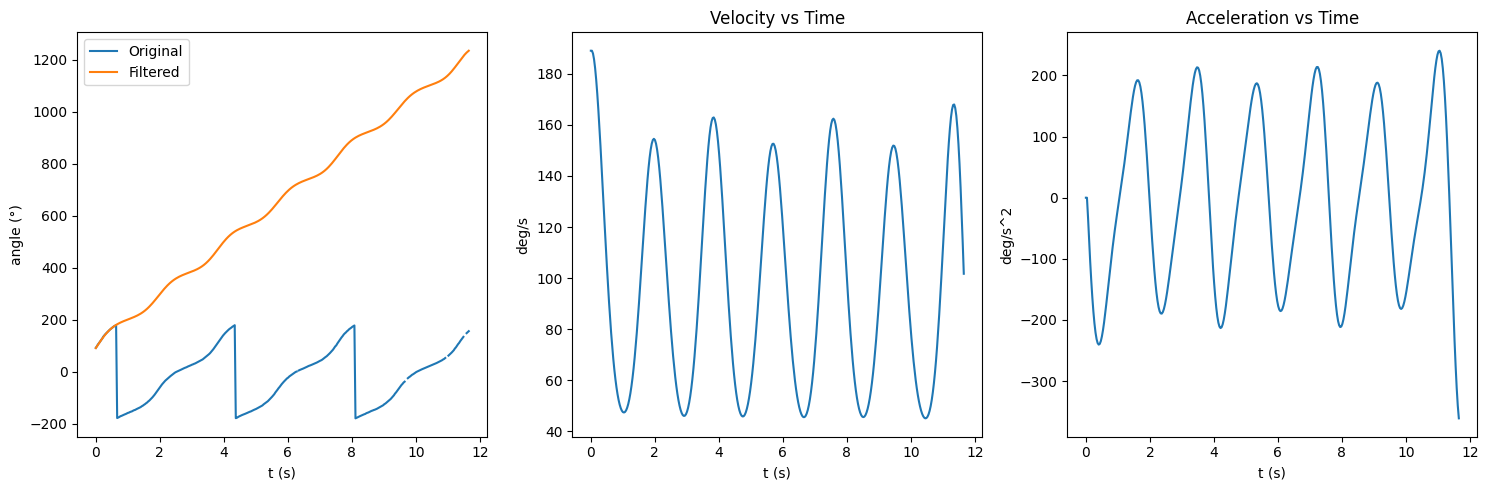

In [16]:
filename = "rotate_left_bottom_1.csv"
df = pd.read_csv(filename)[:350]

type = "x (mm)"
accel = get_accel(type, df)

type = "y (mm)"
accel = get_accel(type, df)

type = "angle (°)"
accel = get_accel(type, df)

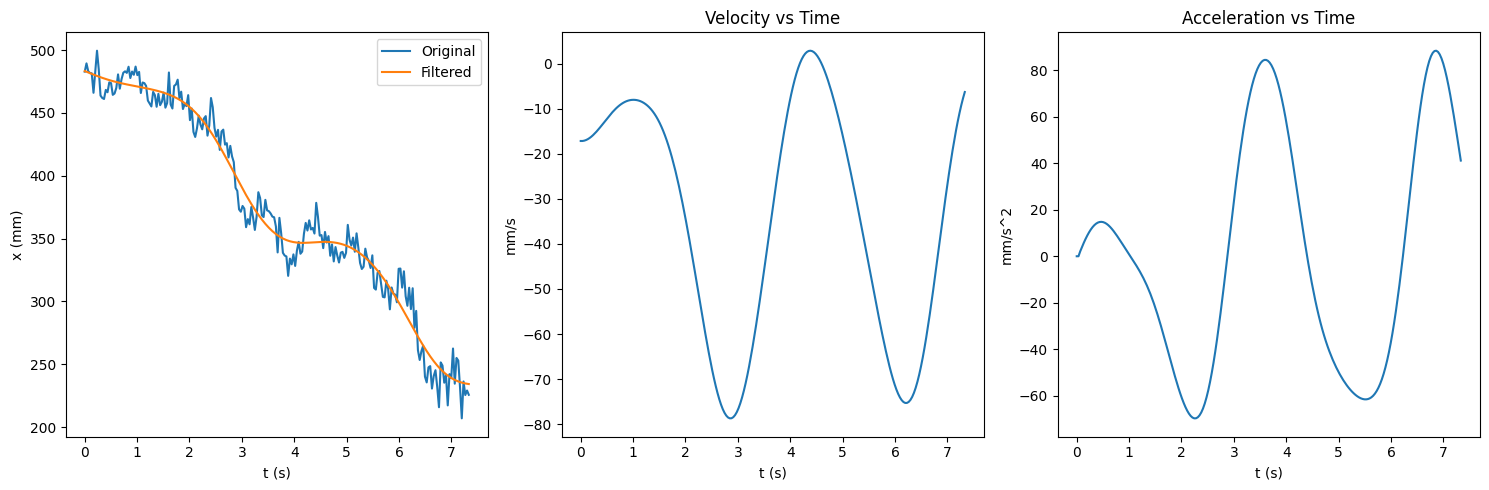

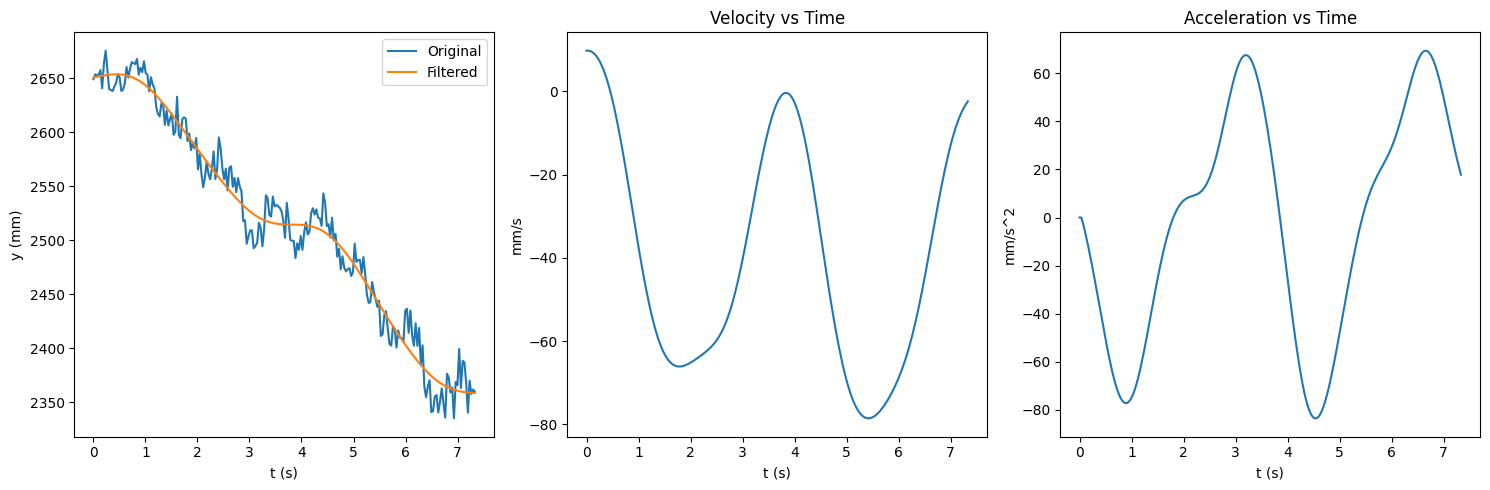

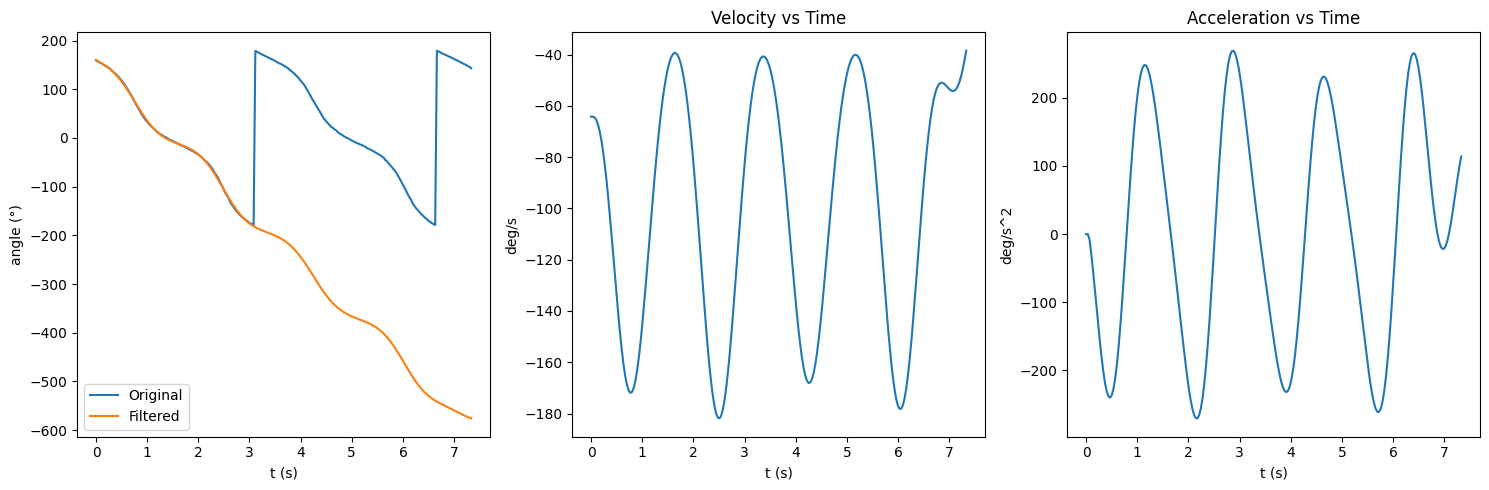

In [19]:
filename = "rotate_left_top_1.csv"
df = pd.read_csv(filename)

type = "x (mm)"
accel = get_accel(type, df)

type = "y (mm)"
accel = get_accel(type, df)

type = "angle (°)"
accel = get_accel(type, df)

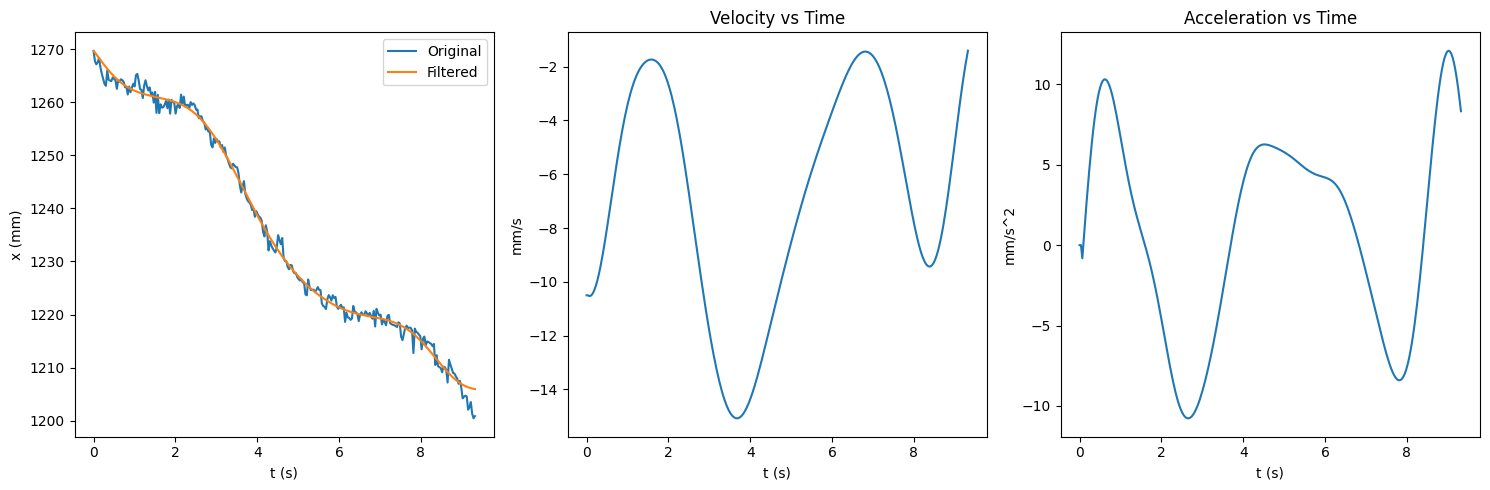

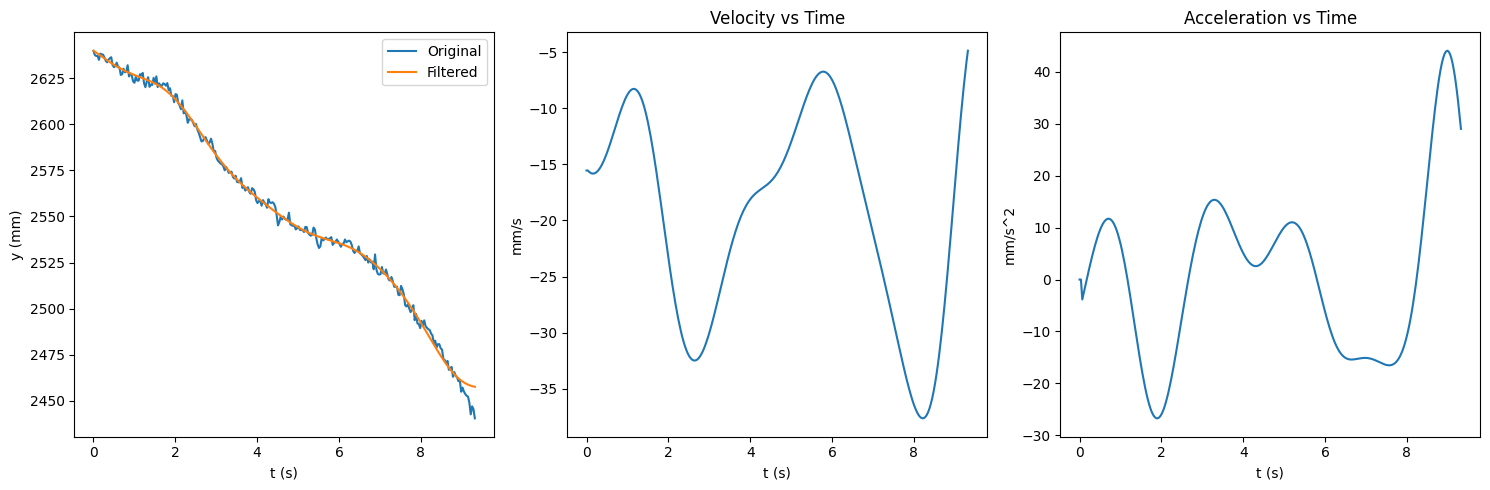

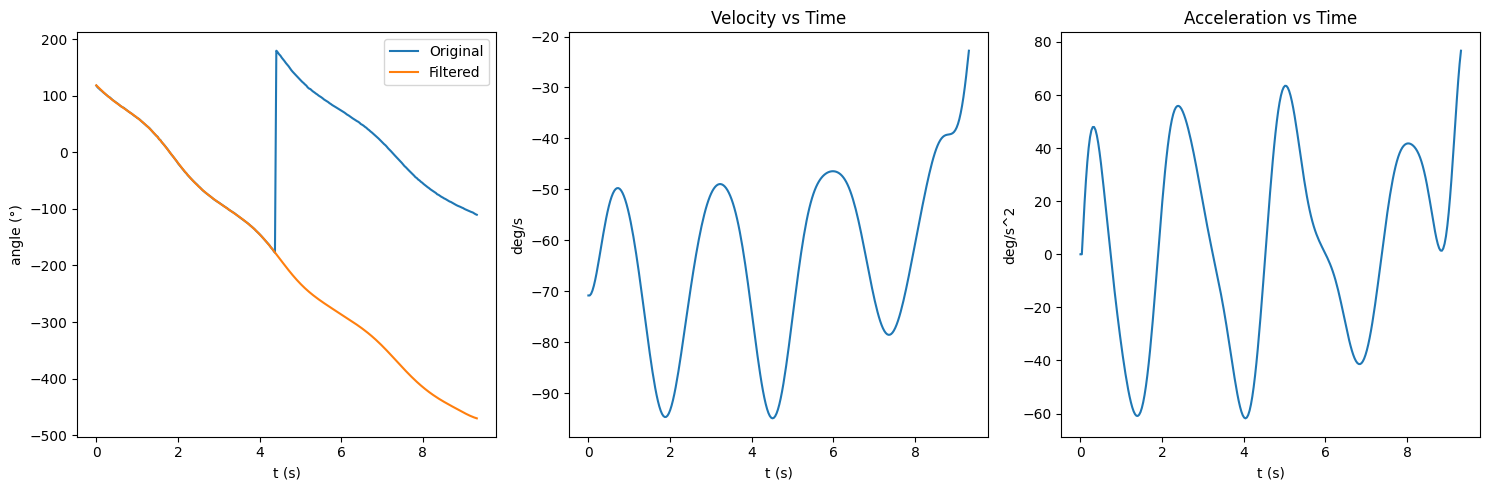

In [34]:
filename = "rotate_right_top_1.csv"
df = pd.read_csv(filename)[:280]

type = "x (mm)"
accel = get_accel(type, df)

type = "y (mm)"
accel = get_accel(type, df)

type = "angle (°)"
accel = get_accel(type, df)

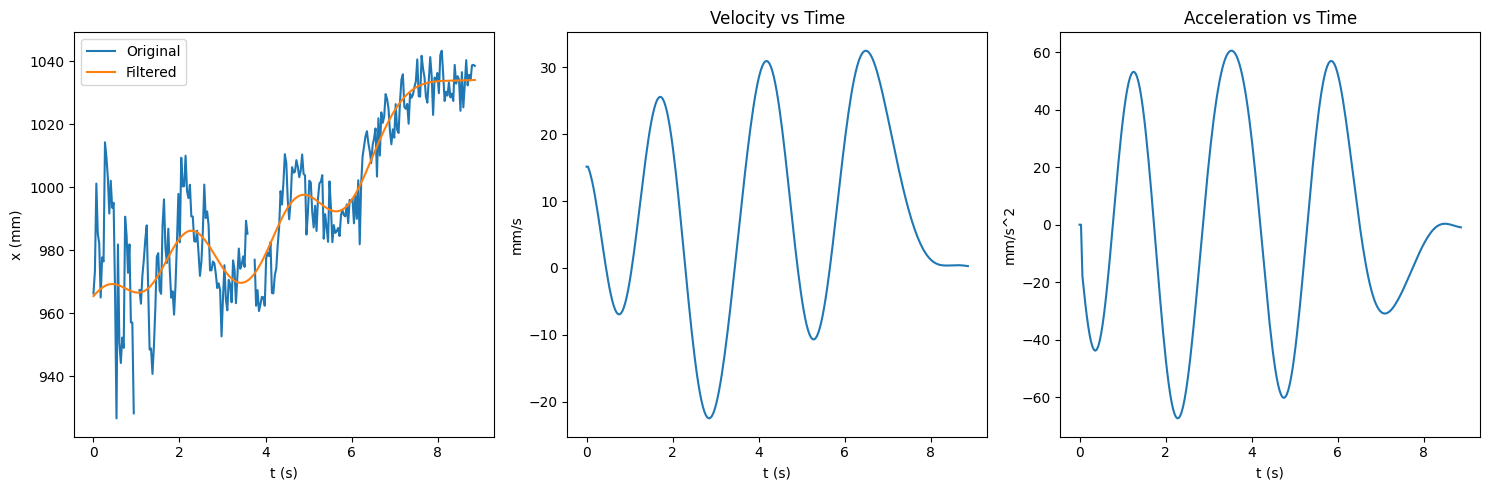

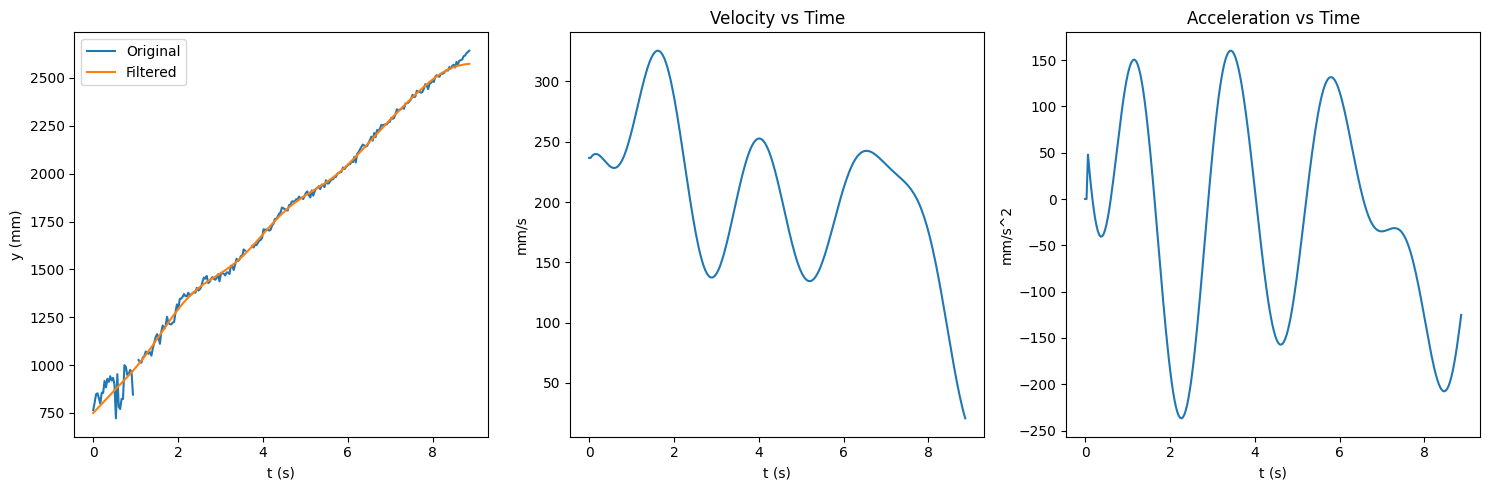

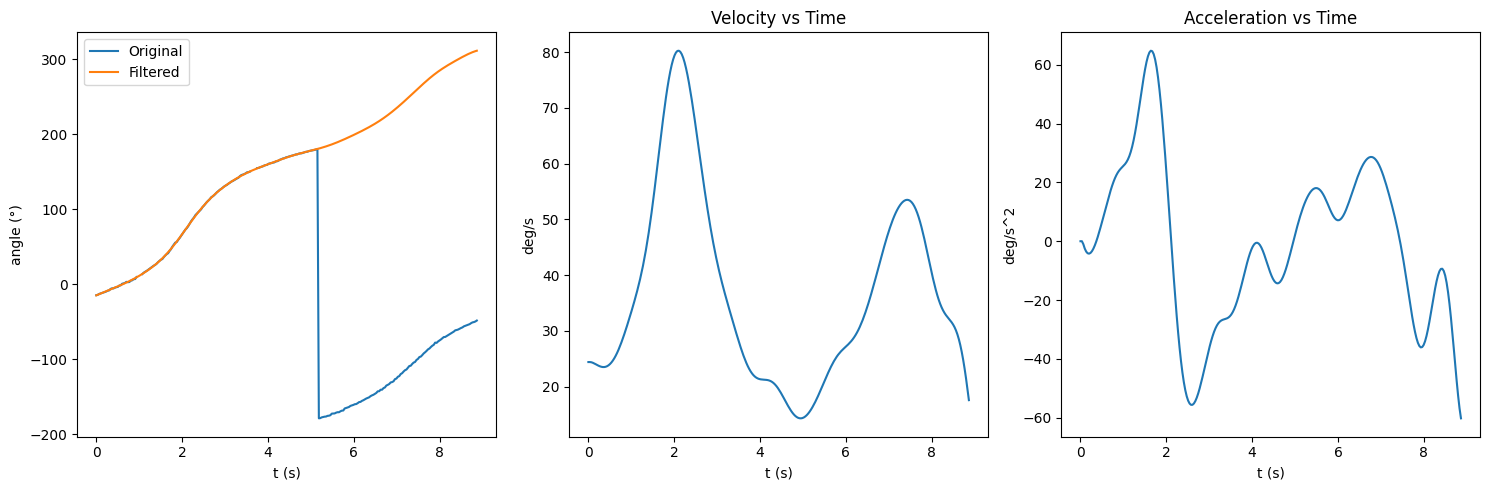

In [23]:
filename = "RotateLine_left_top_1.csv"
df = pd.read_csv(filename)

type = "x (mm)"
accel = get_accel(type, df)

type = "y (mm)"
accel = get_accel(type, df)

type = "angle (°)"
accel = get_accel(type, df)

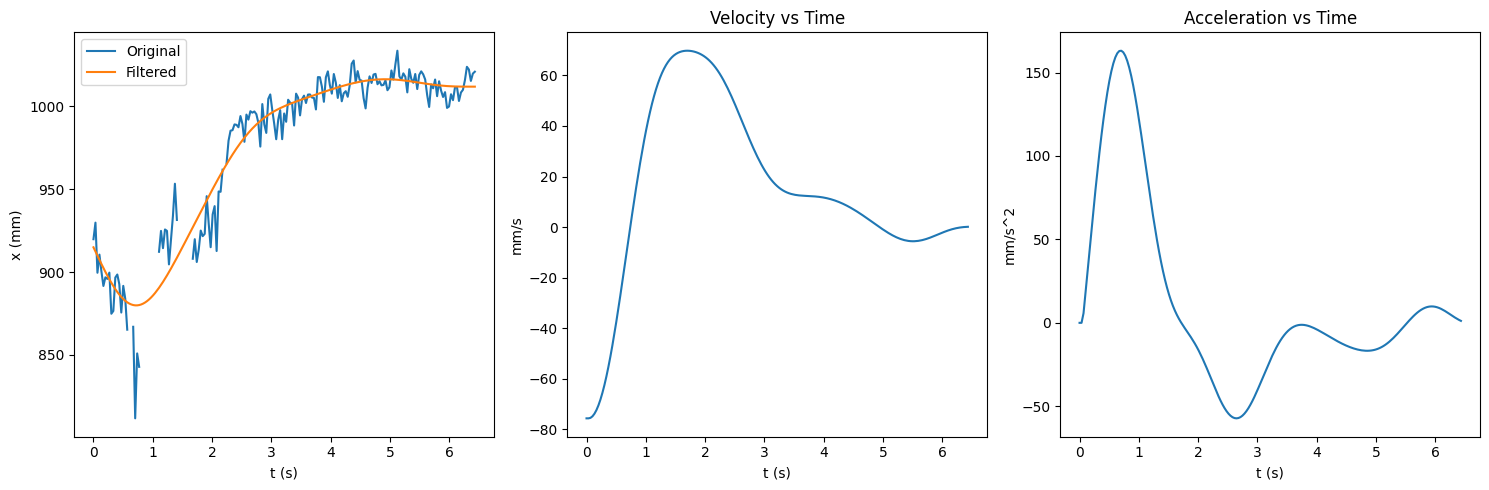

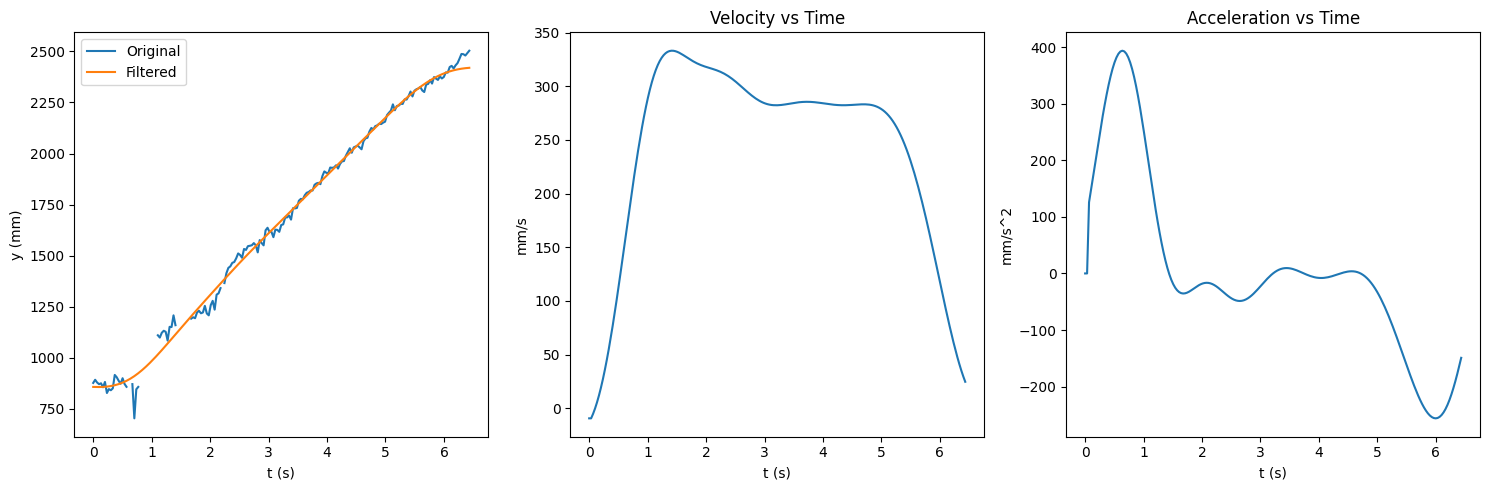

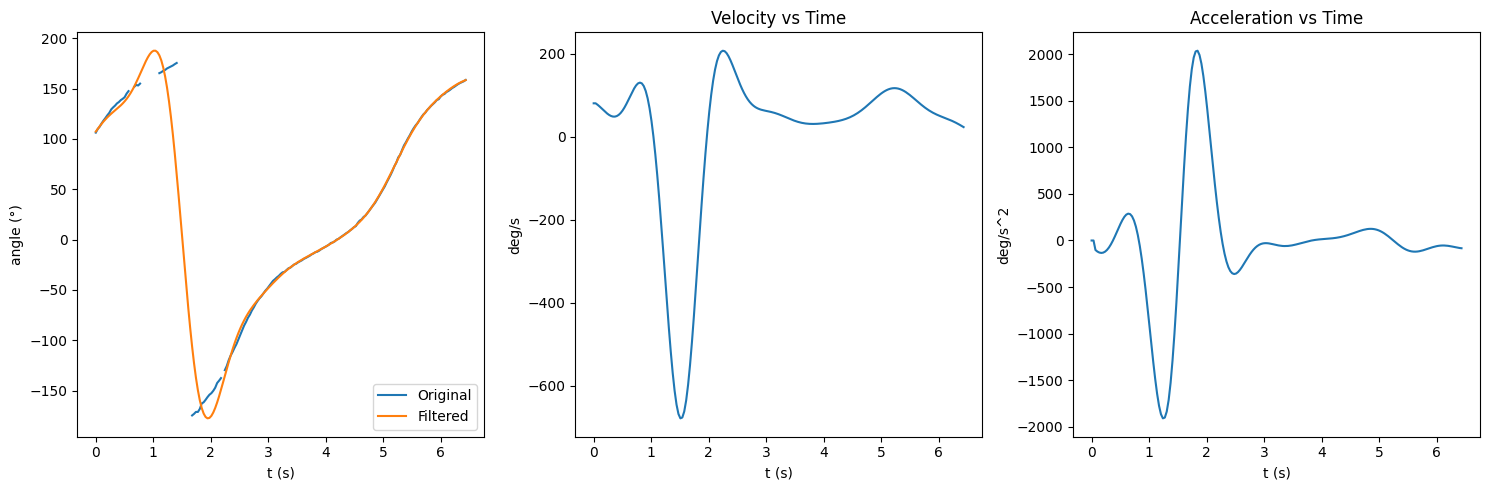

In [24]:
filename = "RotateLineFaster_left_top_1.csv"
df = pd.read_csv(filename)

type = "x (mm)"
accel = get_accel(type, df)

type = "y (mm)"
accel = get_accel(type, df)

type = "angle (°)"
accel = get_accel(type, df)

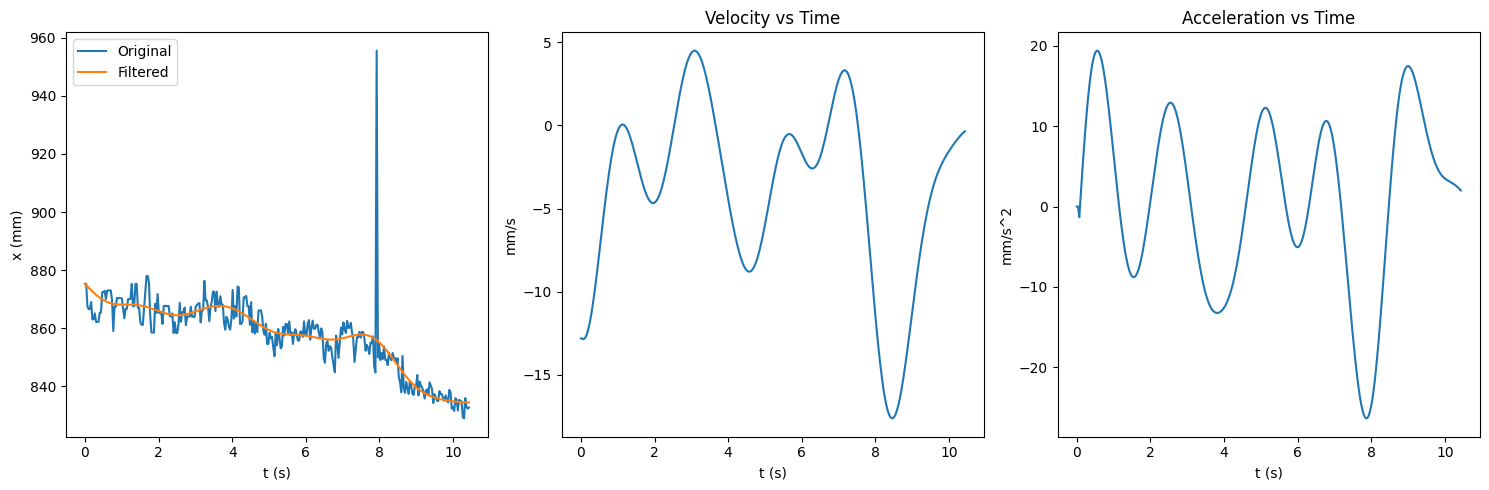

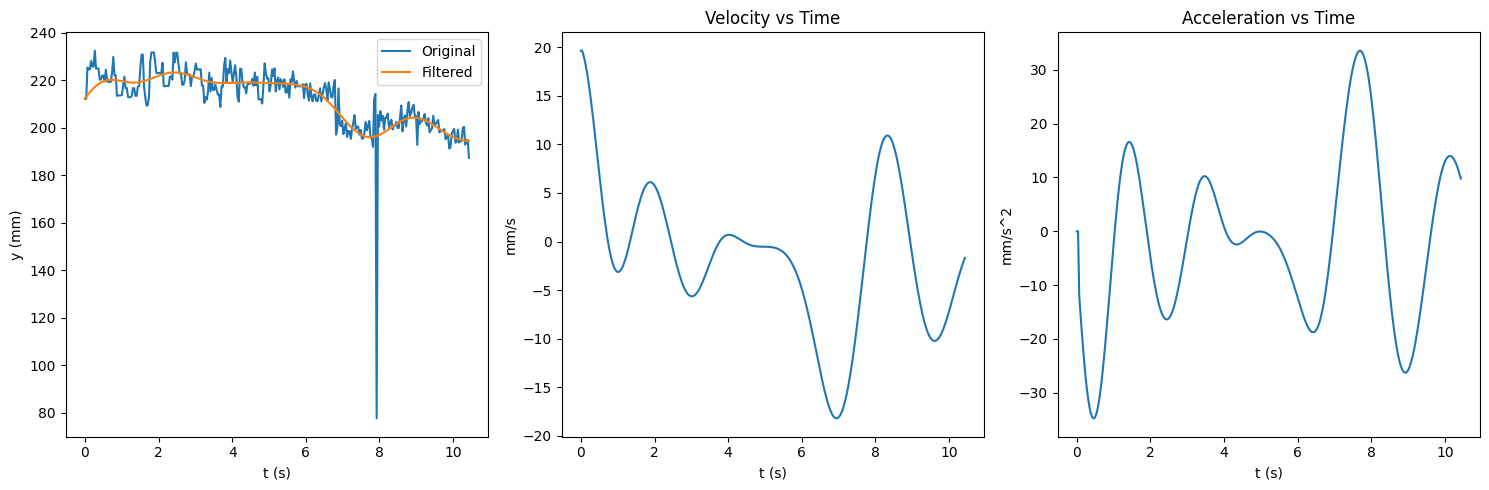

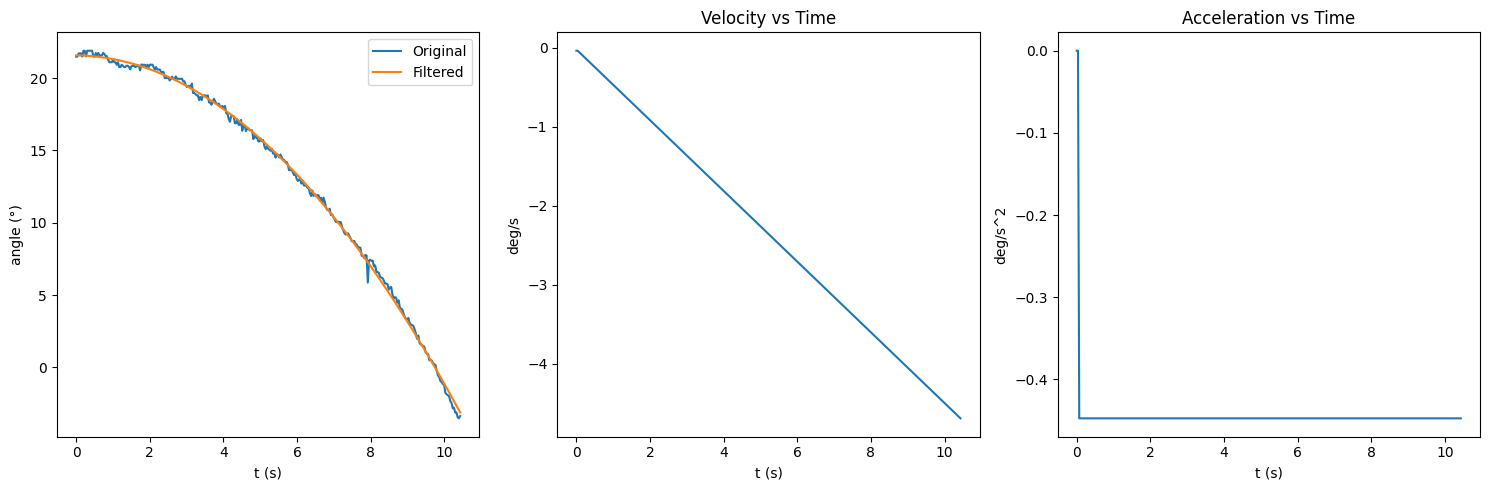

In [26]:
filename = "steady_left_bottom_1.csv"
df = pd.read_csv(filename)

type = "x (mm)"
accel = get_accel(type, df)

type = "y (mm)"
accel = get_accel(type, df)

type = "angle (°)"
accel = get_accel(type, df, polyfit=True)

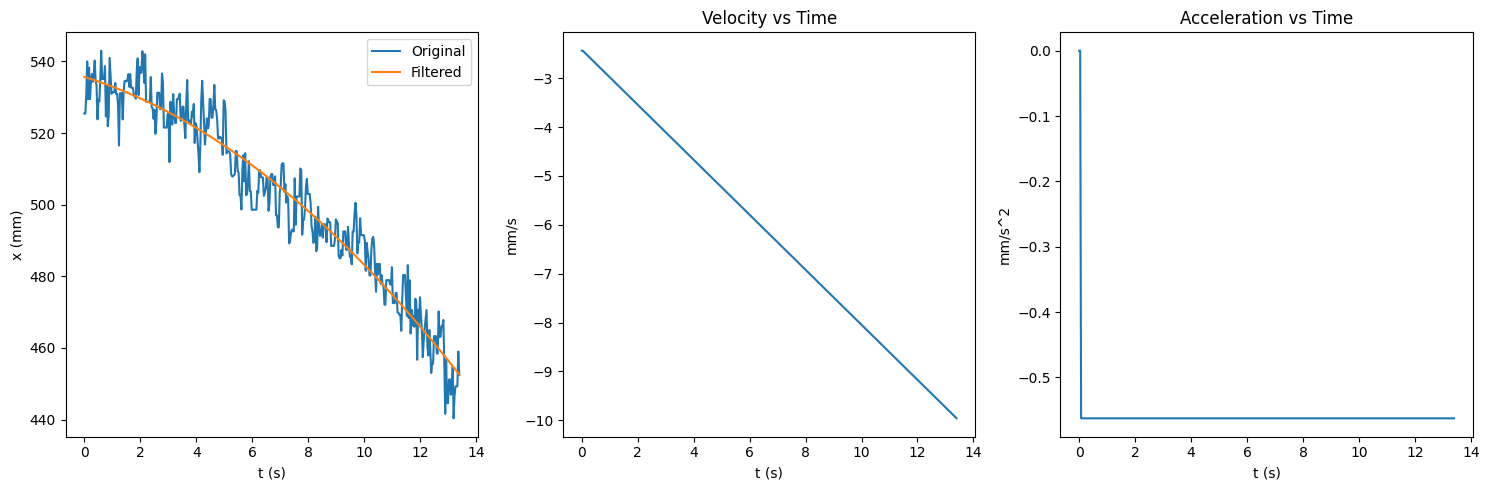

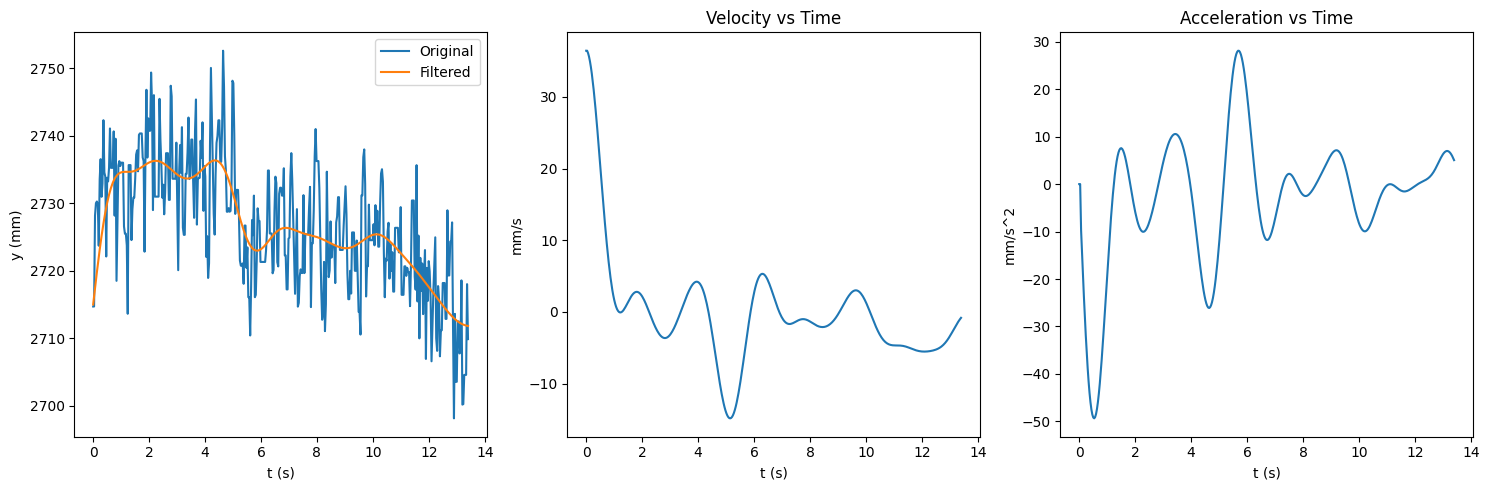

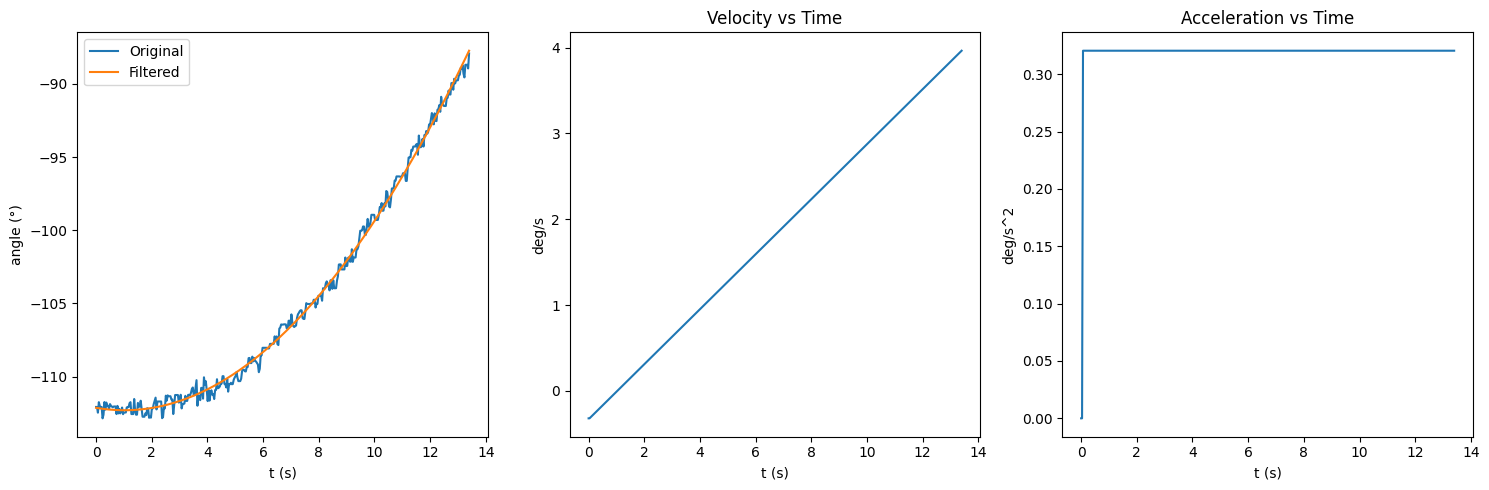

In [29]:
filename = "steady_left_top_1.csv"
df = pd.read_csv(filename)

type = "x (mm)"
accel = get_accel(type, df, polyfit = True)

type = "y (mm)"
accel = get_accel(type, df)

type = "angle (°)"
accel = get_accel(type, df, polyfit=True)